## Notebook to fit triple orbits with astrometry + rv

In [161]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,astrometry_model_vlti,rv_model,rv_model_circular,triple_model,triple_model_circular,triple_model_combined,triple_model_vlti_combined,triple_model_vlti,triple_model_combined_circular,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model,triple_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
from uncertainties import ufloat,umath
from uncertainties.umath import *
import emcee
import corner
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [162]:
## setup paths for user
path = '/Users/tgardne/ARMADA_orbits'
path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
path_wds = '/Users/tgardne/ARMADA_orbits'
path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'

In [169]:
## Specify target
target_hd = '1976' ## HD number
note = 'rv' ## note for saved file
corrected = 'n' ## bootstrap errors?

In [170]:
query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

HIP 1921
WDS 00243+5201


In [165]:
###########################################
## Read in ARMADA data
###########################################
if corrected == 'y':
    print('reading boostrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

file_rv=open('%s/HD_%s_rv.txt'%(path,target_hd))

weight_rv = 2 ## km/s error

t_rv,rv,err_rv = read_rv(file_rv,weight_rv)
file_rv.close()

reading chi2 errors


MJD? (y,[n]):  n


In [168]:
## print rv for paper
for i,j in zip(t_rv,rv):
    print('& %s & %s & -- & -- & -- \\\\'%(i,j))

& 59296.5142 & -27.2 & -- & -- & -- \\
& 59309.4629 & 35.3 & -- & -- & -- \\
& 59315.4621 & 31.4 & -- & -- & -- \\
& 59317.4626 & 28.6 & -- & -- & -- \\
& 59318.4628 & -25.9 & -- & -- & -- \\
& 59321.4501 & 24.1 & -- & -- & -- \\
& 59327.4109 & 11.4 & -- & -- & -- \\
& 59328.4088 & -6.1 & -- & -- & -- \\
& 59337.3761 & -10.2 & -- & -- & -- \\
& 59338.3762 & 14.3 & -- & -- & -- \\
& 59339.3762 & -13.5 & -- & -- & -- \\
& 59340.3762 & 17.9 & -- & -- & -- \\
& 59341.3764 & -14.5 & -- & -- & -- \\
& 59342.3767 & 22.3 & -- & -- & -- \\
& 59343.3767 & -16.6 & -- & -- & -- \\
& 59344.3769 & 25.4 & -- & -- & -- \\
& 59345.3771 & -19.5 & -- & -- & -- \\
& 59346.3769 & 25.7 & -- & -- & -- \\
& 59347.3769 & -22.3 & -- & -- & -- \\
& 59348.3779 & 29.3 & -- & -- & -- \\
& 59349.3772 & -26.5 & -- & -- & -- \\
& 59350.3775 & 31.8 & -- & -- & -- \\
& 59351.3198 & -29.9 & -- & -- & -- \\
& 59352.3205 & 36.1 & -- & -- & -- \\
& 59353.3476 & -29.5 & -- & -- & -- \\
& 59354.3479 & 35.7 & -- & -- & -- \\
&

In [135]:
### correct PAs based on precession
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [136]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

   date      etalon factor
58702.4063 1.0007370967171085
59044.4081 1.0002019414441545
59152.3097 1.000170490529272
59153.2224 1.0000797280528204
59157.3052 1.0001077438236834
59377.4758 1.0002183755926328
59409.437 1.000265841816449
59433.3846 1.0001301138354115
59482.3556 1.000095456341493
59484.3415 1.0000897047689545


In [137]:
## set etalon factors to 1 for vlti data
vlti = 'n'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
else:
    vlti_idx = []
    
## Apply etalon
etalon = 'y'
if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        print('Setting VLTI correction factors to 1.0')
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')

Applying etalon correction


In [138]:
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

vlti_mask = np.ones(len(t),dtype=bool)
vlti_mask[vlti_idx] = False

Number of WDS data points = 37


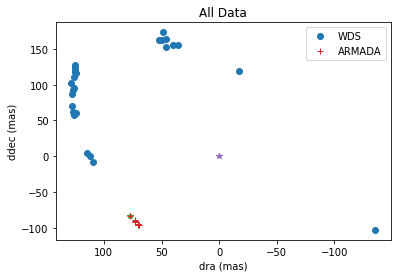

Flip WDS data? (y/n):  n


In [139]:
###########################################
## Read in WDS data - and plot to check
###########################################
input_wds = 'y'
if input_wds == 'y':
    file=open(os.path.expanduser("%s/HD%s_chi2err/HD_%s_wds.txt"%(path_wds,target_hd,target_hd)))
    weight = 1
    t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_data(file,weight)
    print('Number of WDS data points = %s'%len(p_wds))

    ## correct WDS for PA
    #theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    idx = np.argmin(t)

    plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
    plt.plot(xpos_wds[0],ypos_wds[0],'*')
    plt.plot(xpos[idx],ypos[idx],'*')
    if len(vlti_idx)>0:
        plt.plot(xpos[vlti_mask],ypos[vlti_mask],'+',label='ARMADA-CHARA')
        plt.plot(xpos[vlti_idx],ypos[vlti_idx],'+',label='ARMADA-VLTI')
    else:
        plt.plot(xpos,ypos,'+',label='ARMADA')
    plt.plot(0,0,'*')
    plt.gca().invert_xaxis()
    plt.title('All Data')
    plt.xlabel('dra (mas)')
    plt.ylabel('ddec (mas)')
    plt.legend()
    plt.show()

    flip = input('Flip WDS data? (y/n): ')
    if flip=='y':
        xpos_wds=-p_wds*np.sin(theta_wds)
        ypos_wds=-p_wds*np.cos(theta_wds)
        plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
        plt.plot(xpos_wds[0],ypos_wds[0],'*')
        plt.plot(xpos[idx],ypos[idx],'*')
        plt.plot(xpos,ypos,'+',label='ARMADA')
        plt.plot(0,0,'*')
        plt.gca().invert_xaxis()
        plt.title('All Data')
        plt.xlabel('dra (mas)')
        plt.ylabel('ddec (mas)')
        plt.legend()
        plt.show()

        better = input('Flip data back to original? (y/n): ')
        if better=='y':
            xpos_wds=p_wds*np.sin(theta_wds)
            ypos_wds=p_wds*np.cos(theta_wds)
else:
    t_wds = np.array([np.nan])
    p_wds = np.array([np.nan])
    theta_wds = np.array([np.nan])
    error_maj_wds = np.array([np.nan])
    error_min_wds = np.array([np.nan])
    error_pa_wds = np.array([np.nan])
    error_deg_wds = np.array([np.nan])
    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    print('NO WDS DATA')

In [140]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6')
    
self_params = 'n'
if self_params=='y':
    a = float(input('a (mas): '))
    P = float(input('P (year): '))*365.25
    e = float(input('ecc : '))
    inc = float(input('inc (deg): '))
    omega = float(input('omega (deg): '))
    bigomega = float(input('bigomega (deg): '))
    T = float(input('T (mjd): '))

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
214.0 169.29 0.163 64.8 311.8 30.1 35130.04553200002
--------------------------


In [141]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

vlti_mask_all = np.ones(len(t_all),dtype=bool)
vlti_mask_all[vlti_idx] = False

In [142]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(astrometry_model_vlti, params, fcn_args=(xp[vlti_mask_all],yp[vlti_mask_all],tp[vlti_mask_all],
                                                        emaj[vlti_mask_all],emin[vlti_mask_all],epa[vlti_mask_all],
                                                        xp[vlti_idx],yp[vlti_idx],tp[vlti_idx],
                                                        emaj[vlti_idx],emin[vlti_idx],epa[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                        emaj,emin,epa),
                                nan_policy='omit')
        result = minner.minimize()

    # write error report
    print(report_fit(result))

    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
    resids_wds = astrometry_model(result.params,xpos_wds,ypos_wds,t_wds,error_maj_wds,
                                 error_min_wds,error_pa_wds)
    ndata_armada = 2*sum(~np.isnan(xpos))
    ndata_wds = 2*sum(~np.isnan(xpos_wds))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
    chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-7)
    print('-'*10)
    print('chi2 armada = %s'%chi2_armada)
    print('-'*10)
    print('chi2 wds = %s'%chi2_wds)
    print('-'*10)

    ## plot fit
    scale=1
    if chi2_armada<1.0 and chi2_armada>0:
        scale=1/np.sqrt(chi2_armada)
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']
    mirc_scale_start = result.params['mirc_scale']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    if len(vlti_idx)>0:
        ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
        ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
    else:
        ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 74
    # variables        = 7
    chi-square         = 74.1033628
    reduced chi-square = 1.10602034
    Akaike info crit   = 14.1032907
    Bayesian info crit = 30.2317464
[[Variables]]
    w:           310.642813 +/- 7.57805100 (2.44%) (init = 311.8)
    bigw:        27.8357186 +/- 0.72166773 (2.59%) (init = 30.1)
    inc:         64.4634992 +/- 0.70190674 (1.09%) (init = 64.8)
    e:           0.19493106 +/- 0.01551137 (7.96%) (init = 0.163)
    a:           217.747400 +/- 6.62075031 (3.04%) (init = 214)
    P:           64843.8693 +/- 2752.85417 (4.25%) (init = 61790.85)
    T:           34430.3356 +/- 1093.07340 (3.17%) (init = 35130.05)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, T)      =  0.990
    C(w, P)      =  0.980
    C(inc, e)    =  0.965
    C(bigw, T)   =  0.962
    C(P, T)      =  0.961
    C(a, P)      =  0.956
    C

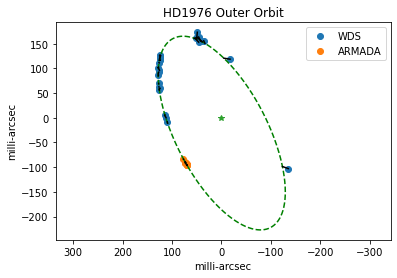

In [143]:
###########################################
## Do a least-squares fit
###########################################
params = Parameters()
params.add('w',   value= omega, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

In [144]:
## scale errors to fit again
chara_scale = 1
vlti_scale = 1
wds_scale = 1 

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
    error_maj_wds/=wds_scale
    error_min_wds/=wds_scale
    error_maj_all[len(xpos):]/=wds_scale
    error_min_all[len(xpos):]/=wds_scale
    
else:
    error_maj/=chara_scale
    error_min/=chara_scale
    error_maj_all[:len(error_maj)]/=chara_scale
    error_min_all[:len(error_maj)]/=chara_scale
    
    error_maj_wds/=wds_scale
    error_min_wds/=wds_scale
    error_maj_all[len(xpos):]/=wds_scale
    error_min_all[len(xpos):]/=wds_scale

----------
chi2 armada = 2.171474968744335
----------


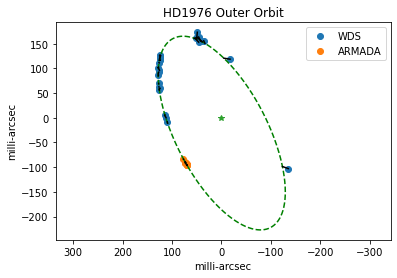

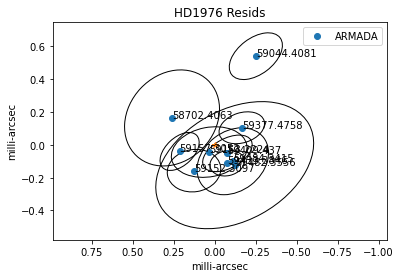

----------
Mean residual = 185.23 micro-as
----------


In [145]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if corrected == 'y':
    directory='%s/HD%s_bootstrap_triple/'%(path,target_hd)
else:
    directory='%s/HD%s_chi2err_triple/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  mirc_scale_start.value,resids_median))
f.close()

In [159]:
##########################################
## User input for additional companions
##########################################
P2 = 25.4
a2 = 0.4
inc2= 100
circular = 'n'

include_rv = 'y'

In [160]:
P2_best = []
a2_best = []
e2_best = []
w2_best = []
bigw2_best = []
inc2_best = []
T2_best = []
P_best = []
a_best = []
e_best = []
w_best = []
bigw_best = []
inc_best = []
T_best = []
mirc_scale_best = []
chi2_results = []

K_best = []
gamma_best = []

for i in tqdm(np.arange(100)):
    bigw2 = random.uniform(0,360)
    T2 = random.uniform(57000,59000)
    if include_rv=='y':
        K = random.uniform(-50,50)
        gamma = random.uniform(-30,30)
    if circular!='y':
        e2 = random.uniform(0,0.99)
        w2 = random.uniform(0,360)
    if inc2=='n':
        inc2_guess = random.uniform(0,180)

    params = Parameters()
    if circular=='y':
        params.add('e2',value=0,vary=False)
        params.add('w2',value=0,vary=False)
    else:
        params.add('e2',value=e2,min=0,max=0.99)
        params.add('w2',value=w2,min=0,max=360)
    params.add('w',   value= w_start, min=0, max=360)
    params.add('bigw', value= bigw_start, min=0, max=360)
    params.add('inc', value= inc_start, min=0, max=180)
    params.add('e', value= e_start, min=0, max=0.99)
    params.add('a', value= a_start, min=0)
    params.add('P', value= P_start, min=0)
    params.add('T', value= T_start, min=0)
    params.add('bigw2', value= bigw2, min=0, max=360)
    if inc2=='n':
        params.add('inc2', value= inc2_guess, min=0, max=180)
    else:
        params.add('inc2', value= inc2, min=0, max=180)
    params.add('a2', value= a2, min=0)
    params.add('P2', value= P2, min=0)
    params.add('T2', value= T2, min=0)
    if include_rv=='y':
        params.add('K',value=K)
        params.add('gamma',value=gamma)
    if len(vlti_idx)>0:
        params.add('mirc_scale', value=1)
    else:
        params.add('mirc_scale',value=1,vary=False)

    #do fit, minimizer uses LM for least square fitting of model to data
    if include_rv=='y':
        if len(vlti_idx)>0:
            minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx],rv,t_rv,err_rv),
                                nan_policy='omit')
            result = minner.minimize()
        else:
            minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                                error_maj_all,error_min_all,
                                                                error_pa_all,rv,t_rv,err_rv),
                                nan_policy='omit')
            result = minner.minimize()
        #try:
        #    print(report_fit(result))
        #except:
        #    print('No fit report')
        
    else:
        if len(vlti_idx)>0:
            minner = Minimizer(triple_model_vlti, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx]),
                                nan_policy='omit')
            result = minner.minimize()
        else:
            minner = Minimizer(triple_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                                error_maj_all,error_min_all,
                                                                error_pa_all),
                                nan_policy='omit')
            result = minner.minimize()
        #try:
        #    print(report_fit(result))
        #except:
        #    print('No fit report')

    P2_best.append(result.params['P2'])
    a2_best.append(result.params['a2'])
    e2_best.append(result.params['e2'])
    w2_best.append(result.params['w2'])
    bigw2_best.append(result.params['bigw2'])
    inc2_best.append(result.params['inc2'])
    T2_best.append(result.params['T2'])
    P_best.append(result.params['P'])
    a_best.append(result.params['a'])
    e_best.append(result.params['e'])
    w_best.append(result.params['w'])
    bigw_best.append(result.params['bigw'])
    inc_best.append(result.params['inc'])
    T_best.append(result.params['T'])
    if include_rv=='y':
        K_best.append(result.params['K'])
        gamma_best.append(result.params['gamma'])
    mirc_scale_best.append(result.params['mirc_scale'])
    chi2_results.append(result.redchi)

 22%|██▏       | 22/100 [05:13<18:30, 14.24s/it]  


KeyboardInterrupt: 

In [148]:
P2_best = np.array(P2_best)
a2_best = np.array(a2_best)
e2_best = np.array(e2_best)
w2_best = np.array(w2_best)
bigw2_best = np.array(bigw2_best)
inc2_best = np.array(inc2_best)
T2_best = np.array(T2_best)
P_best = np.array(P_best)
a_best = np.array(a_best)
e_best = np.array(e_best)
w_best = np.array(w_best)
bigw_best = np.array(bigw_best)
inc_best = np.array(inc_best)
T_best = np.array(T_best)
if include_rv=='y':
    K_best = np.array(K_best)
    gamma_best = np.array(gamma_best)
mirc_scale_best = np.array(mirc_scale_best)
chi2_results = np.array(chi2_results)

idx = np.argmin(chi2_results)
P2_best = P2_best[idx]
a2_best = a2_best[idx]
e2_best = e2_best[idx]
w2_best = w2_best[idx]
bigw2_best = bigw2_best[idx]
inc2_best = inc2_best[idx]
T2_best = T2_best[idx]
P_best = P_best[idx]
a_best = a_best[idx]
e_best = e_best[idx]
w_best = w_best[idx]
bigw_best = bigw_best[idx]
inc_best = inc_best[idx]
T_best = T_best[idx]
if include_rv=='y':
    K_best = K_best[idx]
    gamma_best = gamma_best[idx]
mirc_scale_best = mirc_scale_best[idx]

In [152]:
## Save a fit for errors
params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

if include_rv=='y':
    params.add('K', value= K_best)
    params.add('gamma', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if include_rv=='y':
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    include_rv = 'y'
else:
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx]),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all),
                            nan_policy='omit')
        result = minner.minimize()

report_fit(result)
    
P2_best = result.params['P2'].value
a2_best = result.params['a2'].value
e2_best = result.params['e2'].value
w2_best = result.params['w2'].value
bigw2_best = result.params['bigw2'].value
inc2_best = result.params['inc2'].value
T2_best = result.params['T2'].value
P_best = result.params['P'].value
a_best = result.params['a'].value
e_best = result.params['e'].value
w_best = result.params['w'].value
bigw_best = result.params['bigw'].value
inc_best = result.params['inc'].value
T_best = result.params['T'].value
if include_rv=='y':
    K_best = result.params['K'].value
    gamma_best = result.params['gamma'].value
mirc_scale_best = result.params['mirc_scale'].value

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 172
    # data points      = 125
    # variables        = 16
    chi-square         = 103.802371
    reduced chi-square = 0.95231533
    Akaike info crit   = 8.77188434
    Bayesian info crit = 54.0249041
[[Variables]]
    w:           309.006336 +/- 7.38936262 (2.39%) (init = 309.3106)
    bigw:        27.7014651 +/- 0.67911497 (2.45%) (init = 27.71781)
    inc:         64.4723002 +/- 0.69690386 (1.08%) (init = 64.52133)
    e:           0.19438217 +/- 0.01502959 (7.73%) (init = 0.1954172)
    a:           216.706919 +/- 6.51786942 (3.01%) (init = 217.1093)
    P:           64429.7635 +/- 2650.94219 (4.11%) (init = 64566.94)
    T:           34178.3261 +/- 1053.82505 (3.08%) (init = 34219.98)
    w2:          342.919408 +/- 21.1382366 (6.16%) (init = 342.8775)
    e2:          0.13391874 +/- 0.04544600 (33.94%) (init = 0.1336095)
    bigw2:       358.263178 +/- 17.4996793 (4.88%) (init = 359.0168)
    inc2:  

In [153]:
##########################################
## Save Plots for Triple
##########################################
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
    
    resids_vlti = triple_model_vlti(result.params,np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),
                                    np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
    
    resids_chara = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),
                                    np.array([np.nan]),np.array([np.nan]),np.array([np.nan]))
    
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
    
ndata_armada = 2*sum(~np.isnan(xpos))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-12)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-14)

print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if len(vlti_idx)>0:
    ndata_vlti = 2*sum(~np.isnan(xpos[vlti_idx]))
    ndata_chara = 2*sum(~np.isnan(xpos)) - 2*sum(~np.isnan(xpos[vlti_idx]))
    print(ndata_vlti)
    print(ndata_chara)
    if circular=='y':
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-12)
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-12)
    else:
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-14)
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-14)
        
    print('-'*10)
    print('chi2 chara = %s'%chi2_chara)
    print('-'*10)
    print('chi2 vlti = %s'%chi2_vlti)
    print('-'*10)

----------
chi2 armada = 1.0598577392447295
----------


In [121]:
1/np.sqrt(0.2)

2.23606797749979

In [151]:
## scale errors to fit again

armada_scale = 1
vlti_scale = 1
chara_scale = 1

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
else:
    error_maj/=armada_scale
    error_min/=armada_scale
    error_maj_all[:len(error_maj)]/=armada_scale
    error_min_all[:len(error_maj)]/=armada_scale

In [154]:
if len(vlti_idx)>0:
    xpos[vlti_idx]*=mirc_scale_best
    ypos[vlti_idx]*=mirc_scale_best
    xpos_all[vlti_idx]*=mirc_scale_best
    ypos_all[vlti_idx]*=mirc_scale_best
else:
    idx = np.where(t<58757)
    xpos[idx]/=mirc_scale_best
    ypos[idx]/=mirc_scale_best
    idx = np.where(t_all<58757)
    xpos_all[idx]/=mirc_scale_best
    ypos_all[idx]/=mirc_scale_best

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
    print(scale)
else:
    scale=float(input('scale errors by: '))

ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,t_all)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all)

scale errors by:  1


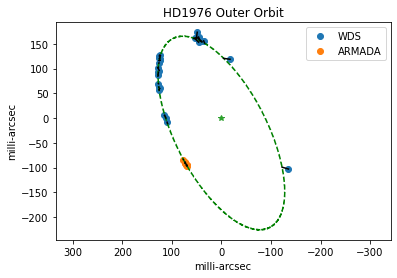

/Users/tgardne/armada_binaries/orbit_plotting.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmodel=='None':
/Users/tgardne/armada_binaries/orbit_plotting.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmodel=='None':


Only plotting best


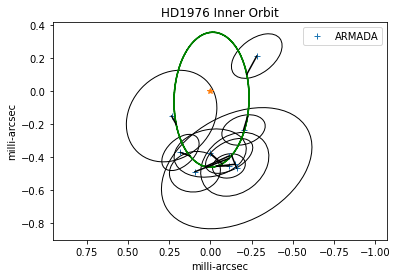

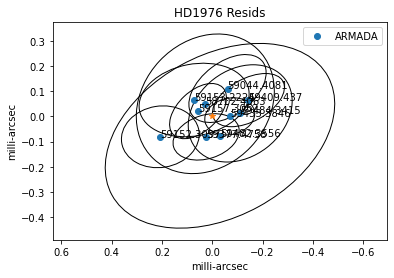

----------
Mean residual = 91.19 micro-as
----------


In [155]:
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

## plot inner wobble
#idx = np.where(error_maj/scale<1)
ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

print('Only plotting best')
elim = 0.5
idx = np.where(error_maj/scale<elim)

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)][idx],ypos_inner[:len(xpos)][idx],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg,t):
    if w<elim:
        ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                            angle=90-angle, facecolor='none', edgecolor='black')
        ax.add_patch(ellipse)
    #ax.annotate(d,xy=(ras,decs))

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)][idx]):
    x=[xpos_inner[:len(xpos)][idx][i],rapoints_inner[:len(xpos)][idx][i]]
    y=[ypos_inner[:len(xpos)][idx][i],decpoints_inner[:len(xpos)][idx][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)
    ax.annotate(d,xy=(ras,decs))

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_triple.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) P2 a2 e2 i2 w2 W2 T2 mirc_scale K gamma mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s"%(P_best,
                                    a_best,e_best,
                                   inc_best,w_best,
                                   bigw_best,T_best,
                                   P2_best,a2_best,e2_best,
                                   inc2_best,w2_best,
                                   bigw2_best,T2_best,
                                  mirc_scale_best,K_best,
                                  gamma_best,resids_median))
f.close()

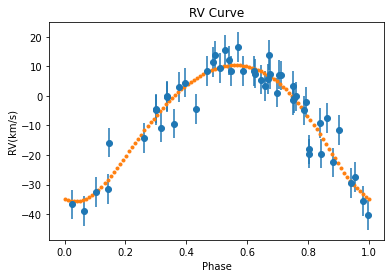

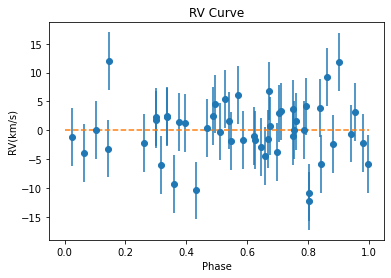

In [156]:
#Plot RV results:
w2_rv = w2_best*np.pi/180+np.pi
foldtime= foldAt(t_rv,P2_best,T0=T2_best)
tt=np.linspace(T2_best,T2_best+P2_best,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE.append(ee_anom)
EE=np.asarray(EE)
MM2=[]
for i in t_rv:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM2.append(mm_anom)
MM2=np.asarray(MM2)
EE2=[]

for j in MM2:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE2.append(ee_anom)
EE2=np.asarray(EE2)

f=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE/2))
y1=K_best*(np.cos(w2_rv+f)+e2_best*np.cos(w2_rv))+gamma_best
tt_fold=foldAt(tt,P2_best,T0=T2_best)

fpoints=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE2/2))
y1points=K_best*(np.cos(w2_rv+fpoints)+e2_best*np.cos(w2_rv))+gamma_best

plt.errorbar(foldtime,rv,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'.')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

plt.errorbar(foldtime,rv-y1points,yerr=err_rv,fmt='o')
plt.plot([0,1],[0,0],'--')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_resids_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [157]:
idx = t.argsort()

In [158]:
## print info for table

for j,k,l,m,n,o in zip(t[idx],p[idx],theta[idx]*180/np.pi,error_maj[idx],error_min[idx],error_deg[idx]):
    print('& %s & %s & %s & %s & %s & %s \\\\'%(j,np.around(k,3),np.around(l,3),m,n,o))

& 58702.4063 & 113.698 & 137.45 & 0.3005428688224028 & 0.2494088390574801 & 316.79 \\
& 59044.4081 & 115.186 & 140.422 & 0.1759807517883703 & 0.10445003111536157 & 307.2112 \\
& 59152.3097 & 116.676 & 141.388 & 0.1554891925504792 & 0.12200067212929606 & 279.2175 \\
& 59153.2224 & 116.536 & 141.396 & 0.2212329451053798 & 0.14268196802679728 & 281.01099999999997 \\
& 59157.3052 & 116.673 & 141.359 & 0.13566171162122345 & 0.08035347534487851 & 313.2383 \\
& 59377.4758 & 117.839 & 143.245 & 0.1353771066318083 & 0.08661478511201191 & 287.7685 \\
& 59409.437 & 118.243 & 143.511 & 0.15634300751872468 & 0.08519176016493614 & 298.6079 \\
& 59433.3846 & 118.464 & 143.718 & 0.10065529792315951 & 0.07228966731144915 & 282.898 \\
& 59482.3556 & 118.799 & 144.126 & 0.4901846601027005 & 0.3211292963900989 & 118.8268 \\
& 59484.3415 & 118.801 & 144.131 & 0.22464820497836166 & 0.17237575525577833 & 307.57439999999997 \\


In [243]:
## Mass / Orbit Information

a_err = ufloat(result.params['a'].value,result.params['a'].stderr)
P_err = ufloat(result.params['P'].value,result.params['P'].stderr)
T_err = ufloat(result.params['T'].value,result.params['T'].stderr)
e_err = ufloat(result.params['e'].value,result.params['e'].stderr)
w_err = ufloat(result.params['w'].value,result.params['w'].stderr)
bigw_err = ufloat(result.params['bigw'].value,result.params['bigw'].stderr)
inc_err = ufloat(result.params['inc'].value,result.params['inc'].stderr)

a2_err = ufloat(result.params['a2'].value,result.params['a2'].stderr)
P2_err = ufloat(result.params['P2'].value,result.params['P2'].stderr)
T2_err = ufloat(result.params['T2'].value,result.params['T2'].stderr)
e2_err = ufloat(result.params['e2'].value,result.params['e2'].stderr)
w2_err = ufloat(result.params['w2'].value,result.params['w2'].stderr)
bigw2_err = ufloat(result.params['bigw2'].value,result.params['bigw2'].stderr)
inc2_err = ufloat(result.params['inc2'].value,result.params['inc2'].stderr)

if include_rv=='y':
    K_err = ufloat(result.params['K'].value,result.params['K'].stderr)
    gamma_err = ufloat(result.params['gamma'].value,result.params['gamma'].stderr)

## distance from HIP/GAIA
plx_hip = ufloat(0.00803,0.00073)
plx_gaia = ufloat(0.0050417,0.0000781)

## Radial Velocity parameters included
semi1 = P2_err*24*60*60*abs(K_err)*(1-e2_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc2_err*np.pi/180)
#print(semi1)

#mratio_err = K_ab_err / K_aa_err
#d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
d_rv = semi1 / (a2_err/1000)
#d_rv = semi1 / ((a2_err - a1_err)/1000)

print('Distance from HIP = ')
print(1/plx_hip)
print('Distance from GAIA = ')
print(1/plx_gaia)
print('Distance from RV = ')
print(d_rv)

#d_err = 1/plx_hip
d_err = d_rv

Distance from HIP = 
125+/-11
Distance from GAIA = 
198.3+/-3.1
Distance from RV = 
7.9+/-1.5


In [207]:
print('%s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P_err.nominal_value,a_err.nominal_value,
                                               e_err.nominal_value,inc_err.nominal_value,
                                               w_err.nominal_value,bigw_err.nominal_value,
                                               T_err.nominal_value))
print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P_err.std_dev,a_err.std_dev,
                                                                                  e_err.std_dev,inc_err.std_dev,w_err.std_dev,
                                                                                  bigw_err.std_dev,T_err.std_dev,))
print('--'*10)

if include_rv=='y':
    print('%s & %s & %s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                             e2_err.nominal_value,inc2_err.nominal_value,
                                                             w2_err.nominal_value,bigw2_err.nominal_value,
                                                             T2_err.nominal_value,K_err.nominal_value,
                                                             gamma_err.nominal_value))
    print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P2_err.std_dev,
                                                                                                          a2_err.std_dev,e2_err.std_dev,
                                                                                                          inc2_err.std_dev,w2_err.std_dev,
                                                                                                          bigw2_err.std_dev,T2_err.std_dev,
                                                                                                          K_err.std_dev,gamma_err.std_dev,))
else:
    print('%s & %s & %s & %s & %s & %s & %s & %s & -- & --'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                             e2_err.nominal_value,inc2_err.nominal_value,
                                                             w2_err.nominal_value,bigw2_err.nominal_value,
                                                             T2_err.nominal_value))
    print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & & '%(P2_err.std_dev,
                                                                                                          a2_err.std_dev,e2_err.std_dev,
                                                                                                          inc2_err.std_dev,w2_err.std_dev,
                                                                                                          bigw2_err.std_dev,T2_err.std_dev))

16753 & 114624.93319308538 & 389.15811596082796 & 0.8325303210021938 & 147.8350325260956 & 76.28492873897706 & 230.00373371666475 & 57691.907874894576
-- & $\pm$6918.4074979473135 & $\pm$14.402947266392157 & $\pm$0.007023313969307197 & $\pm$0.5961802965438 & $\pm$1.783658040899983 & $\pm$1.5738257869151133 & $\pm$11.006537135443576
--------------------
16753 & 270.7656088143809 & 1.4686842045683406 & 0.5071576984297353 & 160.02716178272328 & 83.31780905608328 & 265.77697184282437 & 57256.62909607492 & -3.426304104628064 & 24.04533489415819
-- & $\pm$1.0977209616648766 & $\pm$0.038722129008345735 & $\pm$0.02178412223687342 & $\pm$3.933559392621577 & $\pm$8.600940687628167 & $\pm$8.709896480593391 & $\pm$6.894210058586872 & $\pm$0.457742790869921 & $\pm$0.3372299905193755


In [209]:
d_err = 1/plx_gaia
#d_err = d_rv

print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_err*d_err/1000)**3 / (P_err/365.25)**2
print('M1+M2+M3 = %s Msun'%sum1)

## need to assume a mass
m3 = 2.063

print('-'*10)
minner_tot = sum1 - m3
print('M1+M2=',minner_tot)

a_inner_err = (minner_tot * (P2_err/365.25)**2)**(1/3) / d_err
#print(a_inner_err)
semi2 = a_inner_err*1000 - a2_err
mratio_inner = semi2/a2_err
print('Mratio inner = ', mratio_inner)

print('-'*10)
m1 = minner_tot / (1+1/mratio_inner)
m2 = minner_tot - m1
m3 = sum1 - m1 - m2
print('M1=', m1)
print('M2=', m2)
print('M3=', m3)

----------
Masses from distance
----------
M1+M2+M3 = 4.7+/-0.8 Msun
----------
M1+M2= 2.6+/-0.8
Mratio inner =  2.9+/-0.4
----------
M1= 1.9+/-0.7
M2= 0.67+/-0.14
M3= 2.0630000000000006+/-0


In [244]:
#ainner = ((P2_err/365.25)**2 * (minner_tot))**(1/3)
#aouter = ((P_err/365.25)**2 * (sum1))**(1/3)
ainner = a_inner_err/1000*d_rv
aouter = a_err/1000*d_rv
print('a_inner = %s au'%ainner)
print('a_outer = %s au'%aouter)

print(' ')

mutual_inc1 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))
mutual_inc2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err+180)*np.pi/180))

print("Mutual Inclination = ", mutual_inc1*180/np.pi, 'OR', mutual_inc2*180/np.pi)

a_inner = (4.5+/-0.9)e-05 au
a_outer = (0.0+/-1.5)e+02 au
 
Mutual Inclination =  (0.7+/-3.5)e+02 OR (1.1+/-3.5)e+02


In [138]:
inc2_err

28.178145475291032+/-60.66534469765998